Viscoplastic thermal convection with material transformations.
=====

This notebook demonstrates how to add and control multiple materials in a swarm in an Underworld2 simulation. We use a 'material graph' to represent the material model (set of all materials and possible transformations), and provide some basic functionality to setup a graph and apply the material model to the swarm (i.e update the particles).

Other than the addition of a swarm (a passive swarm in this case), the model is identical to the [Tosi et al. Benchmark](https://github.com/underworldcode/underworld2/blob/master/docs/publications/TosiEtAl-2015/TosiParallel.ipynb)

References
-----

1. Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.


Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import time
import numpy as np
import os
import glucifer

Set physical constants and parameters, including the Rayleigh number (*Ra*) and viscosity constants ($\eta^*$ and $\eta_T$) which are common to all Tosi et al cases.

In [2]:
res = 32        # simulation resolution (horizontal and vertical directions)
RA  = 1e2        # Rayleigh number
ETA_T = 1e5      # common viscosity constant
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
ETA0 = 1e-3      # viscosity constant eta^* in Tosi et al
TMAX = 3.0
IMAX = 1000
ppc = 15         #particles per cell in swarm

Select which case of Tosi et al (2015) to use. Must be between 1 and 5.

In [3]:
CASE = 2

Setup a dictonary containing viscosity and stress values for each case.

In [4]:
case_dict = {}
case_dict[1] = {}
case_dict[1]['ETA_Y'] = 1.
case_dict[1]['YSTRESS'] = 1.
case_dict[2] = {}
case_dict[2]['ETA_Y'] = 1.
case_dict[2]['YSTRESS'] = 1.
case_dict[3] = {}
case_dict[3]['ETA_Y'] = 10.
case_dict[4] = {}
case_dict[4]['ETA_Y'] = 10.
case_dict[4]['YSTRESS'] = 1.
case_dict[5] = {}
case_dict[5]['ETA_Y'] = 10.
case_dict[5]['YSTRESS'] = 4.

Set viscosity constants based on which Tosi et al case is being used.

In [5]:
ETA_Y = case_dict[CASE]['ETA_Y']
YSTRESS = case_dict[CASE]['YSTRESS']

Set input and output file directories

In [6]:
# input file directory

inputPath  = 'TosiInput/case' + str(CASE) + "/"

# output files
outputPath = 'TosiOutput/'
filePath   = outputPath+'files'

    
if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

Create mesh and finite element variables
------

Set up mesh and field variables that are solved on the mesh. See user guides for details of this process.

In [7]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial and boundary conditions**

Either set by perturbation function or load data from file.

In [8]:
LoadFromFile = True
savedRes = 128

**If loading from file**

Read (``savedRes`` $\times$ ``savedRes``) resolution data for $P$, $v$ and $T$ fields as well as existing summary statistics data. These are converted into lists so that the main time loop below will append with new values.


In [9]:
if(LoadFromFile == True):
# set up mesh for savedRes*savedRes data file
    meshSaved = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                       elementRes  = (savedRes, savedRes), 
                                       minCoord    = (0., 0.), 
                                       maxCoord    = (1., 1.) )
    temperatureFieldSaved    = uw.mesh.MeshVariable( mesh=meshSaved,         nodeDofCount=1 )
    temperatureDotFieldSaved = uw.mesh.MeshVariable( mesh=meshSaved,         nodeDofCount=1 )
    pressureFieldSaved       = uw.mesh.MeshVariable( mesh=meshSaved.subMesh, nodeDofCount=1 )
    velocityFieldSaved       = uw.mesh.MeshVariable( mesh=meshSaved,         nodeDofCount=2 )

    temperatureFieldSaved.load(    inputPath+'temperatureField.h5' )
    temperatureDotFieldSaved.load( inputPath+'temperatureDotField.h5' )
    pressureFieldSaved.load(       inputPath+'pressureField.h5')
    velocityFieldSaved.load(       inputPath+'velocityField.h5')
    
    if(res==savedRes): # no remeshing needed, copy data directly
        temperatureField.data[:]    = temperatureFieldSaved.data[:]
        pressureField.data[:]       = pressureFieldSaved.data[:]
        velocityField.data[:]       = velocityFieldSaved.data[:]
        temperatureDotField.data[:] = temperatureDotFieldSaved.data[:]
    else: # remeshing needed
        temperatureField.data[:]    = temperatureFieldSaved.evaluate( mesh )
        pressureField.data[:]       = pressureFieldSaved.evaluate( mesh.subMesh )
        velocityField.data[:]       = velocityFieldSaved.evaluate( mesh )
        temperatureDotField.data[:] = temperatureDotFieldSaved.evaluate( mesh )
        
    data = np.loadtxt( inputPath+'Summary.txt', unpack=True )
    stepsVal = data[0].tolist()
    timeVal = data[1].tolist()
    viscdiscVal = data[2].tolist()
    nu0Val = data[3].tolist()
    nu1Val = data[4].tolist()
    Avg_tempVal = data[5].tolist()
    vrmsVal = data[6].tolist()
    Rms_surfVal = data[7].tolist()
    Max_vx_surfVal = data[8].tolist()
    GravworkVal = data[9].tolist()
    etamaxVal = data[10].tolist()
    etaminVal = data[11].tolist() 

In [10]:
if(LoadFromFile == False):
# Initialise data.. Note that we are also setting boundary conditions here
    velocityField.data[:]  = [0.,0.]
    pressureField.data[:]  = 0.
    temperatureDotField.data[:] = 0.
    temperatureField.data[:] = 0.
# Setup temperature initial condition via numpy arrays
    A = 0.01
#Note that width = height = 1
    for index, coord in enumerate(mesh.data):
        pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
        temperatureField.data[index] = pertCoeff;    
    stepsVal = []
    timeVal = []
    viscdiscVal = []
    nu0Val = []
    nu1Val = []
    Avg_tempVal = []
    vrmsVal = []
    Rms_surfVal = []
    Max_vx_surfVal = []
    GravworkVal = []
    etamaxVal = []
    etaminVal = []

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [11]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [12]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

Set up material graphs (particle handling)
-----

In [13]:
####################
#This code provides the functionality to update materials using a directed graph data model, from the networkx package
###################

from networkx import DiGraph
import networkx as nx
import numpy as np
from easydict import EasyDict as edict
import operator
import uuid
import underworld as uw
from underworld import function as fn

class MatGraph(DiGraph):
    def __init__(self):
        DiGraph.__init__(self) #Call the parent class init function
        self.number_changed = 1
        self.condition_list = []


    def add_transition(self, nodes, function, FnOperator, value, combineby = 'and'):
        """
        Function that allows you to easily add material transitions in Underworld simulations.
        This function creates graph 'nodes', representing the two materials.
        It also provided a simple way of decribing the rules determining the transision process

        Parameters
        ----------
        nodes : Tuple
            (a,b) represents the possibility of a transition fram material a to material b 
        function: underworld.function._function.Function
            (could also be a constant)
        nOperator: operator
            operators must be provided in function form through the operator package, eg. operator.gt(1., 2.). Only less than and greater than operators are supported.
        value: float
            the value will be compared to the providided function, given the provided operator
        combineby: string
            'and' or 'or', defaults to 'and'. If multiple rules are provided for a single edge in the graph (representing the material transition)
            then they be applied in the sense of any ('or'), or all ('and')
        """
        #only greater than or less than comparisons are supported for conditons
        if not operator.or_(FnOperator.__name__ == ('lt'), FnOperator.__name__ == ('gt')):
            raise AssertionError("FnOperator must be either operator.lt or operator.gt", FnOperator)
        firstEdge = True
            
        try:
            self[nodes[0]][nodes[1]] #see if the node exists
            #get names of previous condition dict:
            prevdname = self[nodes[0]][nodes[1]].keys()[0]
            firstEdge = False
        except:
            self.add_node(nodes[0])
            self.add_node(nodes[1])
            self.add_edges_from([nodes])
        #create a random name for dictionary (we need to have a different key for each condition on the graph edge)
        dname = uuid.uuid4()
        self[nodes[0]][nodes[1]][dname] = {}
        self[nodes[0]][nodes[1]][dname]['function'] = function
        self[nodes[0]][nodes[1]][dname]['operator'] =  FnOperator
        self[nodes[0]][nodes[1]][dname]['value'] =  value
        self[nodes[0]][nodes[1]][dname]['combineby'] = 'and'
        if combineby == 'or':
            self[nodes[0]][nodes[1]][dname]['combineby'] =  'or'
        if not firstEdge:
            assert self[nodes[0]][nodes[1]][dname]['combineby'] == self[nodes[0]][nodes[1]][prevdname]['combineby'], "if the graph has multiple conditions on an edge, provided 'combineby' string must be identical to avoid ambiguity."
    
    def walk_update(self, swarm, materialVariable):
        """
        A function that allows you to update an underworld material swarm, given the directed graph (and rules) describing those transitions

        Parameters
        ----------
        swarm: underworld.swarm._swarm.Swarm
        materialVariable: underworld.swarm._swarmvariable.SwarmVariable

        Notes
        ----------
        A better way of doing this is the future would be to link the graph and conditions directly to the underworld fn.branching.conditional()
        This would amount to writing the graph conditions directly to a condition list.
        """
        self.number_changed = 0
        #Loop through particles
        for particleID in range(swarm.particleCoordinates.data.shape[0]):
            edgeFound = False
            partCoords = [swarm.particleCoordinates.data[particleID][0],swarm.particleCoordinates.data[particleID][1]]
            node = materialVariable.data[particleID][0] #each Mat is represented by a node in the graph
            #Loop through egdes
            for otherNode in self[node].keys(): #Now loop through connected nodes (graph edges)
                if edgeFound:
                    break
                #Loop through conditions on each edge
                for cond in self[node][otherNode].keys(): #Loop though conditions governing material transformation
                    if self[node][otherNode][cond]['operator'](self[node][otherNode][cond]['function'].evaluate(partCoords)[0][0], self[node][otherNode][cond]['value']):
                        edgeFound = otherNode
                        if self[node][otherNode][cond]['combineby'] == 'or':
                            break
                    else:
                        edgeFound = False
                        if self[node][otherNode][cond]['combineby'] == 'and':
                            break

            if edgeFound:
                materialVariable.data[particleID] = edgeFound
                self.number_changed += 1 #Utilising that the True + n = 1 + n

    def build_condition_list(self, materialVariable):
        self.condition_list = [] #empty the condition list
        dm = 1e-6
        for node in self.nodes(): #Loop through nodes of graph
            for otherNode in self[node].keys(): #loop through all egdes from a given node
                #if node < otherNode:
                #this returns true for all particles with materialIndex == node (direct comparison isn't supported)
                checkFrom = operator.and_((materialVariable > (node - dm) ), 
                           (materialVariable < (node + dm) ))
                condIt = 0
                for cond in self[node][otherNode].keys(): #loop through all conditions attached to the graph edge
                    op = self[node][otherNode][cond]['operator']    #
                    fun = self[node][otherNode][cond]['function']   #{extract function, operator, value}
                    val = self[node][otherNode][cond]['value']      #
                    condExp = op(fun, val)  #Now provide the function & value to the operator, return result as a variable
                    if condIt == 0:
                        totCond = condExp #if this is the first condition, assign to totCond
                    else: #if this is the NOT first condition, combine conditin with previous totCond (using AND or OR)
                        if self[node][otherNode].values()[0]['combineby'] == 'or':
                            totCond = operator.or_(totCond, condExp) 
                        else:
                            totCond = operator.and_(totCond, condExp) 
                    condIt += 1
                    
                #When we pass this on to fn.branching.conditional, we only want to apply it to paticles where 
                # matIndex == node, which occurs where checkFrom == True, 1   
                combCond = operator.and_(totCond, checkFrom) 
                #combCond = totCond
                self.condition_list.append(((combCond), otherNode))
        self.condition_list.append((True ,          materialVariable)) #if no conditions are true, return current matId

In [14]:
#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#create swarm variables
materialVariable = gSwarm.add_variable( dataType="int", count=1 )

# Layouts are used to populate the swarm across the whole domain
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.



In [15]:
#Materials
matname1 = 1
matname2 = 2
matname3 = 3
matname4 = 4



# Swarm variables
materialVariable.data[:] = matname1

#list of all material indexes
material_list = [1,2,3,4]

In [17]:
coordinate = fn.coord()
depthFn = 1. - coordinate[1]
xFn = coordinate[0]

In [18]:
#Setup the graph object
DG = MatGraph()

#First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

###################
#Case1: material transitions a function of location
###################

###################
#anything  => 1
DG.add_transition((matname2,matname1), xFn, operator.lt, 0.5)
DG.add_transition((matname2,matname1), depthFn, operator.lt, 0.5)

DG.add_transition((matname3,matname1), xFn, operator.lt, 0.5)
DG.add_transition((matname3,matname1), depthFn, operator.lt, 0.5)

DG.add_transition((matname4,matname1), xFn, operator.lt, 0.5)
DG.add_transition((matname4,matname1), depthFn, operator.lt, 0.5)


###################
#anything to  => 2
DG.add_transition((matname1,matname2), xFn, operator.gt, 0.5)
DG.add_transition((matname1,matname2), depthFn, operator.lt, 0.5)

DG.add_transition((matname3,matname2), xFn, operator.gt, 0.5)
DG.add_transition((matname3,matname2), depthFn, operator.lt, 0.5)

DG.add_transition((matname4,matname2), xFn, operator.gt, 0.5)
DG.add_transition((matname4,matname2), depthFn, operator.lt, 0.5)

###################
#anything  => 3
DG.add_transition((matname1,matname3), xFn, operator.lt, 0.5)
DG.add_transition((matname1,matname3), depthFn, operator.gt, 0.5)

DG.add_transition((matname2,matname3), xFn, operator.lt, 0.5)
DG.add_transition((matname2,matname3), depthFn, operator.gt, 0.5)


DG.add_transition((matname4,matname3), xFn, operator.lt, 0.5)
DG.add_transition((matname4,matname3), depthFn, operator.gt, 0.5)

###################
#anything  => 4
DG.add_transition((matname1,matname4), xFn, operator.gt, 0.5)
DG.add_transition((matname1,matname4), depthFn, operator.gt, 0.5)

DG.add_transition((matname2,matname4), xFn, operator.gt, 0.5)
DG.add_transition((matname2,matname4), depthFn, operator.gt, 0.5)

DG.add_transition((matname3,matname4), xFn, operator.gt, 0.5)
DG.add_transition((matname3,matname4), depthFn, operator.gt, 0.5)



Populating the interactive namespace from numpy and matplotlib


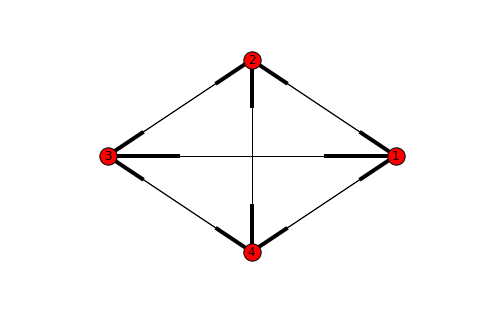

In [19]:
#A simple plot of the material graph

if uw.nProcs() == 1:
    import networkx as nx
    %pylab inline
    nx.draw_circular(DG, with_labels=True)
    plt.show()

In [20]:
#Build the list of conditions

DG.build_condition_list(materialVariable)

DG.condition_list

[(<underworld.function._function.logical_and at 0x7f5c814b1650>, 2),
 (<underworld.function._function.logical_and at 0x7f5c8179ba10>, 3),
 (<underworld.function._function.logical_and at 0x7f5c8143fa10>, 4),
 (<underworld.function._function.logical_and at 0x7f5c81410b50>, 1),
 (<underworld.function._function.logical_and at 0x7f5c8141f4d0>, 3),
 (<underworld.function._function.logical_and at 0x7f5c8141fe90>, 4),
 (<underworld.function._function.logical_and at 0x7f5c81422a90>, 1),
 (<underworld.function._function.logical_and at 0x7f5c813a96d0>, 2),
 (<underworld.function._function.logical_and at 0x7f5c813af310>, 4),
 (<underworld.function._function.logical_and at 0x7f5c813aff10>, 1),
 (<underworld.function._function.logical_and at 0x7f5c813b6b50>, 2),
 (<underworld.function._function.logical_and at 0x7f5c813be790>, 3),
 (True, <underworld.swarm._swarmvariable.SwarmVariable at 0x7f5c8804f2d0>)]

In [28]:
##############
#use the material graph object to test / apply material transformations
##############
materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)


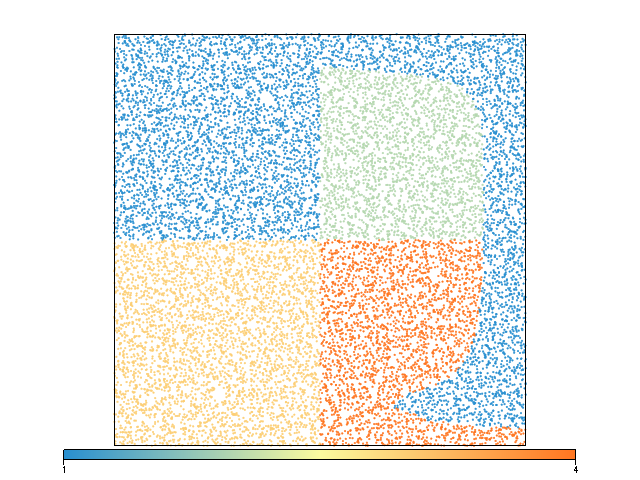

In [29]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Points(gSwarm,materialVariable, fn_size=3))


fig.show()

In [30]:
#Setup the graph object
DG = MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

In [31]:
###################
#Case2: material transitions a function of location and temperature
###################
###################
#anything  => 1
DG.add_transition((matname2,matname1), xFn, operator.lt, 0.5)
DG.add_transition((matname2,matname1), depthFn, operator.lt, 0.5)

DG.add_transition((matname3,matname1), xFn, operator.lt, 0.5)
DG.add_transition((matname3,matname1), depthFn, operator.lt, 0.5)

DG.add_transition((matname4,matname1), xFn, operator.lt, 0.5)
DG.add_transition((matname4,matname1), depthFn, operator.lt, 0.5)

###################
#anything to  => 2
DG.add_transition((matname1,matname2), xFn, operator.gt, 0.5)
DG.add_transition((matname1,matname2), depthFn, operator.lt, 0.5)
DG.add_transition((matname1,matname2), temperatureField, operator.gt, 0.5)


DG.add_transition((matname3,matname2), xFn, operator.gt, 0.5)
DG.add_transition((matname3,matname2), depthFn, operator.lt, 0.5)
DG.add_transition((matname3,matname2), temperatureField, operator.gt, 0.5)


DG.add_transition((matname4,matname2), xFn, operator.gt, 0.5)
DG.add_transition((matname4,matname2), depthFn, operator.lt, 0.5)
DG.add_transition((matname4,matname2), temperatureField, operator.gt, 0.5)


###################
#anything  => 3
DG.add_transition((matname1,matname3), xFn, operator.lt, 0.5)
DG.add_transition((matname1,matname3), depthFn, operator.gt, 0.5)

DG.add_transition((matname2,matname3), xFn, operator.lt, 0.5)
DG.add_transition((matname2,matname3), depthFn, operator.gt, 0.5)


DG.add_transition((matname4,matname3), xFn, operator.lt, 0.5)
DG.add_transition((matname4,matname3), depthFn, operator.gt, 0.5)

###################
#anything  => 4
DG.add_transition((matname1,matname4), xFn, operator.gt, 0.5)
DG.add_transition((matname1,matname4), depthFn, operator.gt, 0.5)
DG.add_transition((matname1,matname4), temperatureField, operator.gt, 0.5)

DG.add_transition((matname2,matname4), xFn, operator.gt, 0.5)
DG.add_transition((matname2,matname4), depthFn, operator.gt, 0.5)
DG.add_transition((matname2,matname4), temperatureField, operator.gt, 0.5)

DG.add_transition((matname3,matname4), xFn, operator.gt, 0.5)
DG.add_transition((matname3,matname4), depthFn, operator.gt, 0.5)
DG.add_transition((matname3,matname4), temperatureField, operator.gt, 0.5)

In [34]:
#reset the materialVariable
materialVariable.data[:] = matname1

In [37]:
##############
#This is how we use the material graph object to test / apply material transformations
##############
DG.build_condition_list(materialVariable)

materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [38]:
DG.condition_list

[(<underworld.function._function.logical_and at 0x7f5c813c5990>, 2),
 (<underworld.function._function.logical_and at 0x7f5c83ae3dd0>, 3),
 (<underworld.function._function.logical_and at 0x7f5c813d1690>, 4),
 (<underworld.function._function.logical_and at 0x7f5c81371250>, 1),
 (<underworld.function._function.logical_and at 0x7f5c83b35310>, 3),
 (<underworld.function._function.logical_and at 0x7f5c81378790>, 4),
 (<underworld.function._function.logical_and at 0x7f5c8139d650>, 1),
 (<underworld.function._function.logical_and at 0x7f5c813a05d0>, 2),
 (<underworld.function._function.logical_and at 0x7f5c813a7c90>, 4),
 (<underworld.function._function.logical_and at 0x7f5c812eb250>, 1),
 (<underworld.function._function.logical_and at 0x7f5c812f2250>, 2),
 (<underworld.function._function.logical_and at 0x7f5c81326150>, 3),
 (True, <underworld.swarm._swarmvariable.SwarmVariable at 0x7f5c8804f2d0>)]


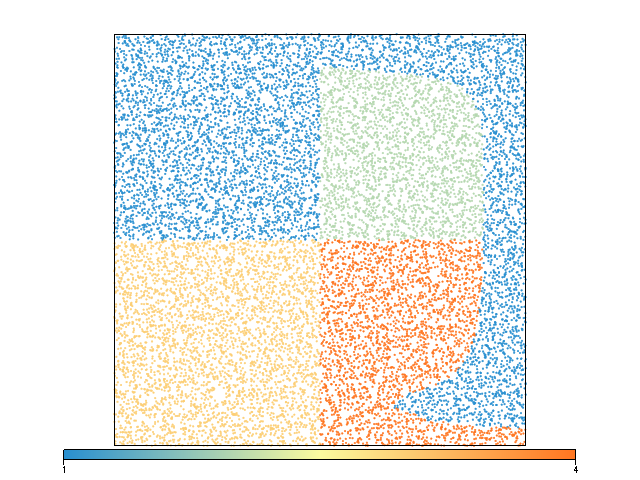

In [39]:

fig.show()

In [40]:
np.unique(materialVariable.data)

array([1, 2, 3, 4], dtype=int32)

Set up rheology
-----

**Viscosity field**

The viscosity is a function of temperature ($T$), the vertical coordinate ($z$) and the strain rate ($\dot{\epsilon}$) and is given by

$$
    \eta(T, z, \dot{\epsilon}) = 2 \left( \frac{1}{\eta_{lin}(T,z)} + \frac{1}{\eta_{plast}(\dot{\epsilon})} \right)^{-1}
$$

where the linear part is

$$
    \eta_{lin}(T, z) = \exp(-\gamma_T T + \gamma_z z)
$$

with $\gamma_T = \ln(\Delta \eta_T)$ and $\gamma_z = \ln(\Delta \eta_z)$. The nonlinear part is

$$
    \eta_{plast}(\dot{\epsilon}) = \eta^* + \frac{\sigma_{\gamma}}{\sqrt{\dot{\epsilon} : \dot{\epsilon}}}
$$

where $\eta^*$ is the effective viscosity at high stresses and $\sigma_{\gamma}$ is the yield stress. The values of $\Delta \eta_T$, $\Delta \eta_z$, $\eta^*$ and $\sigma_{\gamma}$ are assumed to be constant with values dependent on the particular case.

**Create variables required for plasticity calculations**

In [30]:
secinv = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.fn_gradient ) )
coordinate = fn.coord()

**Setup viscosity functions**

Remember to use floats everywhere when setting up functions

In [31]:
viscosityl1 = fn.math.exp(math.log(ETA_T)*-1.*temperatureField)
viscosityl2 = fn.math.exp((math.log(ETA_T)*-1.*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinv/math.sqrt(0.5)) #extra factor to account for underworld second invariant form

if CASE == 1:
    fn_viscosity = viscosityl1
elif CASE == 2:
    fn_viscosity = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    fn_viscosity = viscosityl2
else:
    fn_viscosity = 2./(1./viscosityl2 + 1./viscosityp)

**Add functions for density and buoyancy**

In [32]:
densityFn = RA*temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Build the Stokes system and solvers
------

Setup the Stokes system with linear or nonlinear visocity viscosity depending on case.

In [33]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity   = fn.exception.SafeMaths( viscosityl1), #Linear viscosity for first solve
                               fn_bodyforce   = buoyancyFn )

Setup solver for the Stokes system of equations

In [34]:
solver = uw.systems.Solver( stokesPIC )

We do one solve for initial pressure and velocity with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [35]:
solver.solve( nonLinearIterate=False )

In [36]:
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = fn_viscosity

Create an advective-diffusive system
-----

Setup the system in underworld by flagging the temperature and velocity field variables.

In [37]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField,
                                         fn_diffusivity=1., conditions=[tempBC,] )

Create a swarm advector
-----

In [38]:
passiveadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temperature
$$  \langle T \rangle  = \int\limits^1_0 \!\!\! \int\limits^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers
$$Nu_{top/bot} = - \left. \int^1_0 \frac{\partial T}{\partial y} \right|_{y=1/y=0} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
$$u_{RMS} = \left( \int\limits^1_0 \!\!\! \int\limits^1_0 \left( u_x^2 + u_y^2 \right) dx dy \right)^{1/2}$$
$$u_{RMS}^{surf} = \left( \left. \int\limits_0^1 u_x^2\right|_{y=1} dx \right)^{1/2}$$
$$u_{max}^{surf} = \left. \max(u_x)\right|_{y=1}$$
* max and min viscosity over the whole domain
$$\eta_{max/min} = \max / \min \left( \eta\left(x,y\right) \right)$$
* average rate of work done against gravity
$$\langle W \rangle = \int\limits^1_0 \!\!\! \int\limits^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation
$$\langle \Phi \rangle = \int\limits^1_0 \!\!\! \int\limits^1_0\tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

**Setup volume integrals used in metric functions**

In [39]:
tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( secinv, secinv )
vdint = uw.utils.Integral( (4.*fn_viscosity*sinner), mesh )

**Setup surface integrals used in metric functions**

In [40]:
rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

**Define diagnostic functions using integrals**

In [41]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

Main simulation loop
------

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

Since getting each case to equilibrium takes a long time the default number of steps to do is kept short. Edit this if you wish to go through the entire process yourself.

In [42]:
steps_todo = 10

Initialise steps and time. Set to zero unless loading values from file.

In [43]:
try:
    realtime = timeVal[-1]
    step = int(stepsVal[-1])
except:
    realtime = 0.0
    step = 0
    
steps_end = step + steps_todo
steps_output = 30
steps_output = max(steps_output,1)
swarm_update = 2 # ow often to update the swarm using the material graph

In [44]:
# initialise timer for computation
start = time.clock()
# start loop
while step < steps_end:
    # Solve non-linear system
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    passiveadvector.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    # Calculate the Metrics, only on 1 of the processors:
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf(velocityField, mesh)
    Gravwork = gravwork(dwint)
    Viscdis = viscdis(vdint)
    nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
    etamax, etamin = visc_extr(fn_viscosity)
    # store results
    stepsVal.append(       step)
    timeVal.append(        realtime )
    viscdiscVal.append(    Viscdis )
    nu0Val.append(         nu0 )
    nu1Val.append(         nu1 )
    Avg_tempVal.append(    Avg_temp )
    vrmsVal.append(        Rms )
    Rms_surfVal.append(    Rms_surf )
    Max_vx_surfVal.append( Max_vx_surf )
    GravworkVal.append(    Gravwork )
    etamaxVal.append(      etamax )
    etaminVal.append(      etamin )

    # output fields and summary info to file (output graphics can also be added here)
    if (step % steps_output == 0) or (step == steps_end-1):
        if uw.rank()==0:
            print 'step =',step, '; CPU time =', time.clock()-start, '; vrms = ',Rms
   
            np.savetxt( outputPath + 'Summary.txt', np.c_[stepsVal, timeVal, viscdiscVal,
                            nu0Val, nu1Val, Avg_tempVal, vrmsVal, Rms_surfVal,
                            Max_vx_surfVal, GravworkVal, etamaxVal, etaminVal], 
                            header="Steps, Time, visc, Nusselt bottom/top, av_T, vrms, surf_rms, surf_max, grav, etamax, etamin" )
        # Temperature
        fnametemp = "temperatureField_" + str(step).zfill(6) + ".h5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        temperatureField.save(fullpath)
        # Temperature time derivative
        fnametemp = "temperatureDotField_" + str(step).zfill(6) + ".h5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        temperatureDotField.save(fullpath)
        # Pressure
        fnametemp = "pressureField_" + str(step).zfill(6) + ".h5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        pressureField.save(fullpath)
        # Velocity
        fnametemp = "velocityField_" + str(step).zfill(6) + ".h5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        velocityField.save(fullpath)
        
    #Update the particles at a given time step frequency    
    if step % swarm_update == 0:
        for i in range(1):
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
        

        



step = 43609 ; CPU time = 17.555661 ; vrms =  137.634453636


Save final fields - useful for continuing runs.

In [45]:
velocityField.save(outputPath + 'velocityField.h5')
pressureField.save(outputPath + 'pressureField.h5')
temperatureField.save(outputPath + 'temperatureField.h5')
temperatureDotField.save(outputPath + 'temperatureDotField.h5')
pass


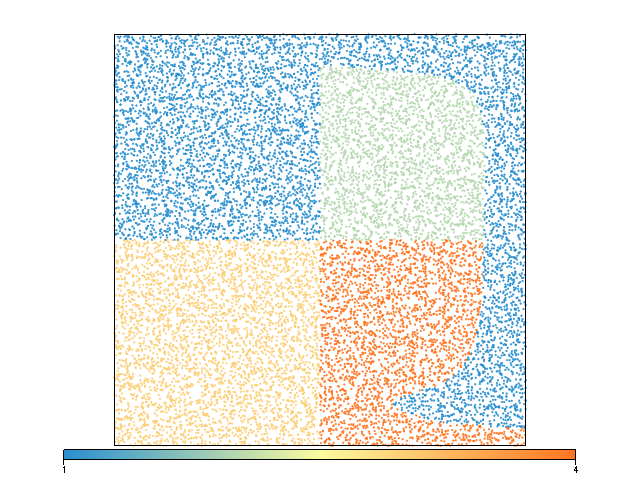

In [46]:
fig.show()

In [47]:
#for i in range(1): #Need to go through a number of times
#    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [48]:
#fig.show()

In [49]:
#fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Surface(mesh,temperatureField, discrete=True))
#fig.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.0005))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.show()
#fig.save_database('test.gldb')


In [64]:
#node = 1
#dta = 1e-6 #small number
#combinedConditions = (materialVariable > (node - dta) ) and \
#                     (materialVariable < (node + dta) )
    
#checkFrom = ((materialVariable > (node- dta)) and (materialVariable < (node+dta))) 

In [59]:
#fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [63]:
#fig= glucifer.Figure(quality=3)
#fig.append( glucifer.objects.Points(gSwarm,checkFrom, fn_size=3))

#fig.show()
#fig.save_database('test.gldb')